In [1]:
import torch
import itertools
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# Reconstruct the model
def model_builder(N, m, k, nonlinearity):
    if nonlinearity == 'ReLU':
        activation = nn.ReLU()
    elif nonlinearity == 'GeLU':
        activation = nn.GELU()
    elif nonlinearity == 'SoLU':
        activation = lambda x: x*torch.exp(x)    
    
    model = torch.nn.Sequential(
                nn.Linear(m, k, bias=True),
                activation,
                nn.Linear(k, N, bias=False)
            )
    return model

In [3]:
model = 'model3' # this is the "baseline" model, no attempt has been made to engineer monosemanticity or penalise polysemanticity
k = 1024 # size of nonlinear layer
log2_batch_size = 13
log2_training_steps = 18
sample_kind = 'equal'
init_bias = 0.0
nonlinearity = 'ReLU'
task = 'autoencoder'
decay = 0.0
eps = 0.015625
m = 64 # input dimensions
N = 512 # number of features
reg = 0.0
lr = 0.03

In [4]:
fname = f"../my_models/{model}_{task}_{nonlinearity}_k_{k}_batch_{log2_batch_size}_steps_{log2_training_steps}_learning_rate_{lr}_sample_{sample_kind}_init_bias_{init_bias}_decay_{decay}_eps_{eps}_m_{m}_N_{N}_reg_{reg}.pt"

In [5]:
batch = torch.load(fname, map_location=torch.device('cpu'))
d = batch['log2_spaced_models'][0]

model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], nonlinearity)
model.load_state_dict(batch['log2_spaced_models'][-1])
model.to('cpu')

fixed_embedder = batch['setup']['fixed_embedder']

# original penalisation term

In [6]:
# calculate the single feature activations
vs = torch.eye(N) # a matrix with only one feature active with unit amplitude. The number of examples matches the number of features.
ins = torch.matmul(vs, fixed_embedder.T) # embed the above matrix with the fixed random embedder
sfa = model[:2].forward(ins).T.detach().numpy() # get the single feature activations of the hidden layer

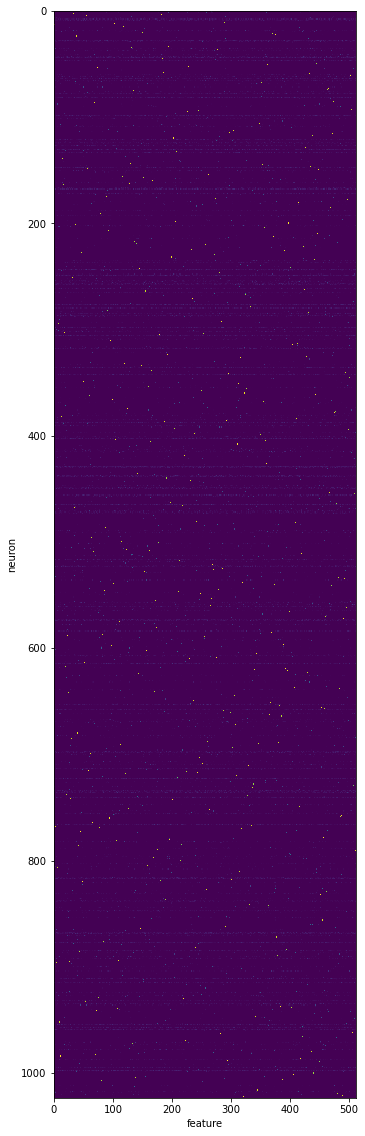

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(sfa, interpolation='nearest', aspect=1.8, vmin=0, vmax=1.02)
plt.xlabel('feature')
plt.ylabel('neuron')
plt.show()

In [8]:
# Sort the neurons to put the most-monosemantic first
inds = np.argsort(-np.amax(sfa,axis=1) / (1e-10 + np.mean(sfa,axis=1)))
sfa = sfa[inds]

# Sort the features to put the most-monosemantic neurons first
neuron_inds = []
for i in range(sfa.shape[1]): # Loop over features
    neuron_ind = np.argmax(sfa[:,i]) # Find the neuron this feature activates most-strongly.
    neuron_inds.append(neuron_ind)
inds = np.argsort(neuron_inds) # Sort the neuron indices
sfa = sfa[:,inds]

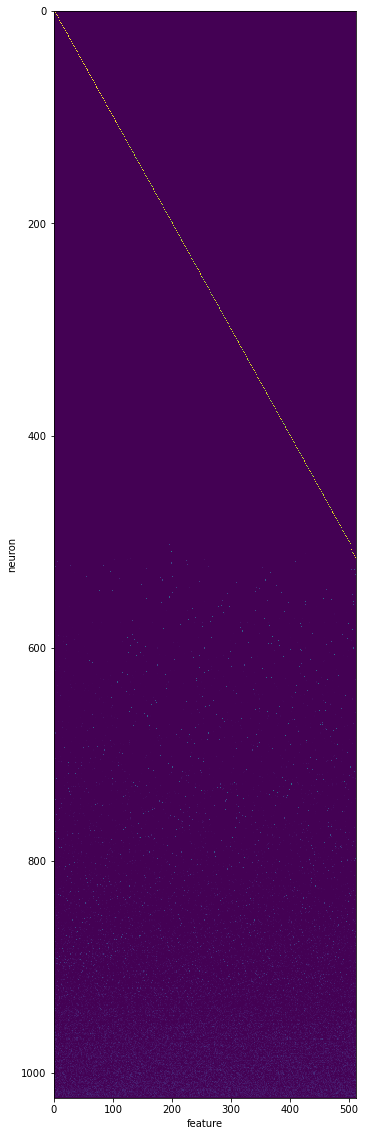

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(sfa, interpolation='nearest', aspect=1.8, vmin=0, vmax=1.02)
plt.xlabel('feature')
plt.ylabel('neuron')
plt.show()

$a$ is matrix of shape n neurons (k) by n features (N) (1024-by-512). 

Each row is a vector of the activations for that feature.

$a \cdot a^{T} = \sum^{k}_{i} \sum^{k}_{j} a_{i}a_{j}$

The diagonal of $a \cdot a^{T}$ i.e. when $j=i$ is a measure of similarity between a neruon's activation vector and itself.



In [10]:
dot = np.dot(sfa, sfa.T) # calculate the inner product of the single feature activations with themselves

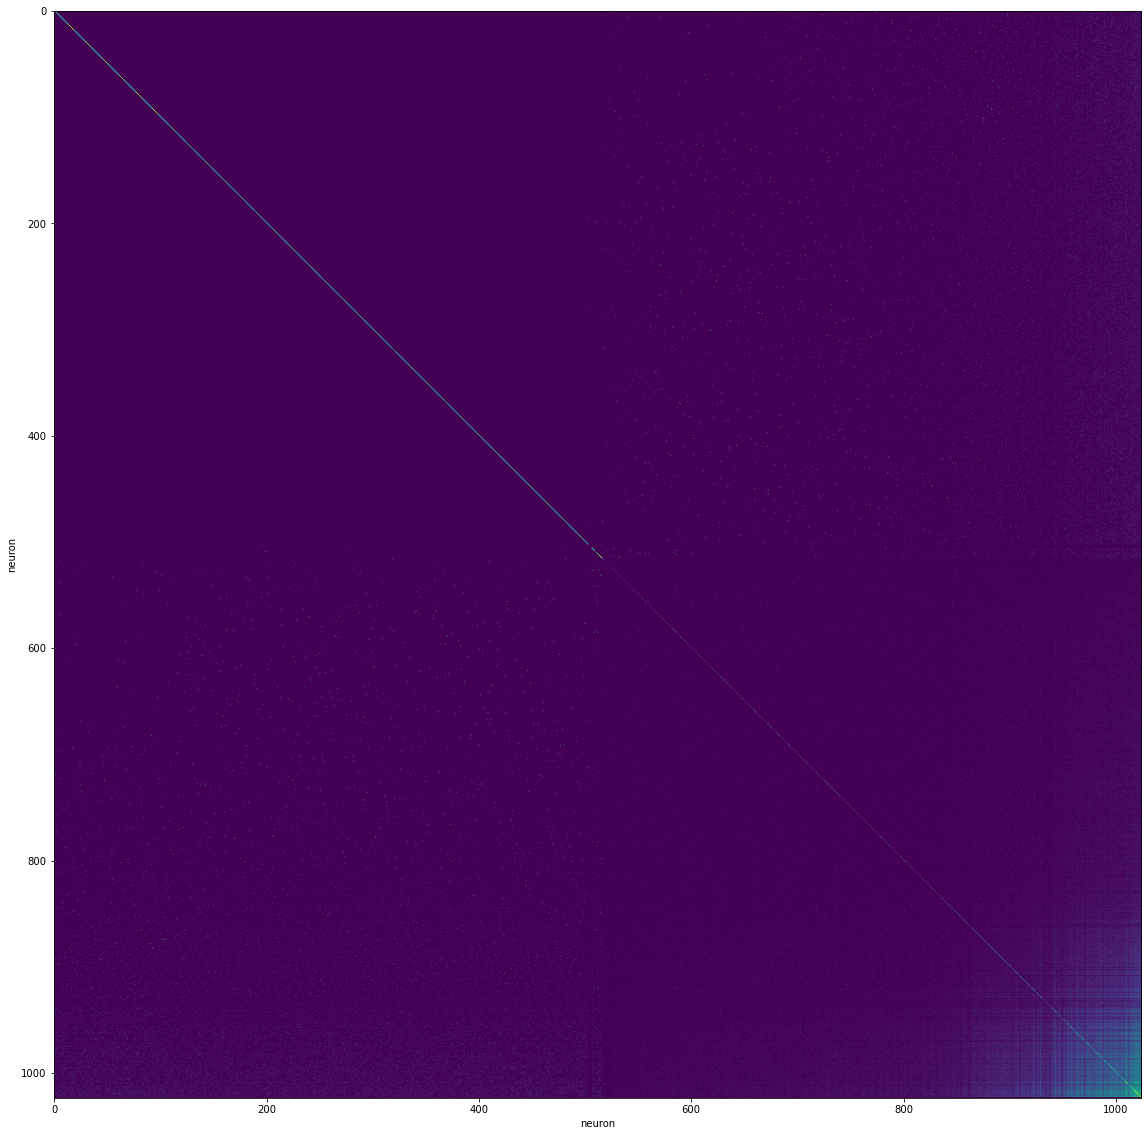

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(dot)
plt.xlabel('neuron')
plt.ylabel('neuron')
plt.show()

The model is penalised by summing up the left triangle, ignoring the leading diagonal, of the inner product of the single feature activations with themselves. This is normalised by the number of comparisons made which is $N(N-1)$.

In [12]:
np.sum(np.tril(dot, -1)) / (N * (N - 1)) # calculate the loss

0.01630431285343058

Repeat the above for using the original penalised approach

In [13]:
model = 'soft_dot_penalised_model' # this is the "penalised" model
lr = 0.001

fname = f"../my_models/{model}_{task}_{nonlinearity}_k_{k}_batch_{log2_batch_size}_steps_{log2_training_steps}_learning_rate_{lr}_sample_{sample_kind}_init_bias_{init_bias}_decay_{decay}_eps_{eps}_m_{m}_N_{N}_reg_{reg}.pt"

batch = torch.load(fname, map_location=torch.device('cpu'))
d = batch['log2_spaced_models'][0]

model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], nonlinearity)
model.load_state_dict(batch['log2_spaced_models'][-1])
model.to('cpu')

fixed_embedder = batch['setup']['fixed_embedder']

# calculate the single feature activations
vs = torch.eye(N) # a matrix with only one feature active with unit amplitude. The number of examples matches the number of features.
ins = torch.matmul(vs, fixed_embedder.T) # embed the above matrix with the fixed random embedder
sfa = model[:2].forward(ins).T.detach().numpy() # get the single feature activations of the hidden layer

dot = np.dot(sfa, sfa.T)

In [14]:
np.sum(np.tril(dot, -1)) / (N * (N - 1)) # calculate the loss

2.548349528787756e-11

The problem with this approach is that it fails to correctly identify all the polysemantic neurons and include them in the loss calculation.

According to the single input features of unit amplitude approach, neuron 0005 in this model is monosemantic and only activates for feature 273.

In [15]:
vs = torch.zeros(N)
vs[272] += 1 # neuron and feature ids are 1-indexed so the index for feature with id 273 is 272.

In [16]:
vs.size()

torch.Size([512])

In [17]:
vs[270:275]

tensor([0., 0., 1., 0., 0.])

In [18]:
ins = torch.matmul(vs, fixed_embedder.T)

In [19]:
ins

tensor([ 0.0651, -0.0492,  0.1565, -0.1259,  0.0759,  0.0055, -0.0153, -0.3933,
        -0.0760,  0.0155,  0.0537,  0.2300, -0.1093,  0.0135, -0.2514, -0.1356,
         0.0797, -0.1764, -0.0453, -0.1068, -0.0584,  0.1036, -0.0308,  0.0926,
         0.1069, -0.0420,  0.0600, -0.1522,  0.2598, -0.1895, -0.0294,  0.0528,
        -0.0843, -0.0923, -0.1321,  0.0366, -0.0619, -0.2710,  0.0574, -0.0163,
        -0.1619, -0.1476,  0.1217, -0.0902, -0.0406, -0.0377, -0.1139,  0.1155,
         0.0188,  0.0445, -0.1945,  0.1940,  0.1120,  0.1212, -0.1243, -0.0476,
         0.2001, -0.1398, -0.0914, -0.0748, -0.0213,  0.0216, -0.0174,  0.0456])

In [20]:
sfa = model[:2].forward(ins).detach().numpy()

In [21]:
sfa[:100]

array([0.        , 0.        , 0.        , 0.        , 0.90033317,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [22]:
print(sfa[4], np.sum(sfa), sfa[4] - np.sum(sfa))

0.90033317 0.90033317 0.0


But when all features but feature 273 are active with unit amplitude neuron 0005 activates for 509 other features.

In [23]:
vs = torch.ones(N)
vs[272] *= 0

In [24]:
vs[270:275]

tensor([1., 1., 0., 1., 1.])

In [25]:
ins = torch.matmul(vs, fixed_embedder.T)
sfa = model[:2].forward(ins).detach().numpy()

In [26]:
sfa[:100]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        6.847509  ,  0.        ,  0.        ,  6.850771  ,  0.        ,
        0.        ,  3.0576446 , 11.237469  ,  2.2833037 ,  2.9758914 ,
        0.44873917,  0.        ,  1.712063  ,  0.        ,  0.        ,
        0.        ,  5.88628   ,  0.9598821 ,  9.262834  ,  0.        ,
        2.0195558 ,  0.        ,  1.78265   ,  8.393884  ,  1.6368589 ,
        4.95702   ,  1.0114834 ,  0.        ,  0.        ,  0.        ,
        0.51323044,  0.        ,  4.104014  ,  0.        ,  2.8302374 ,
        0.        ,  0.        ,  6.77818   ,  0.        , 18.95854   ,
        1.9328694 ,  0.        ,  0.        ,  0.        , 10.078501  ,
        0.        ,  3.2128906 ,  0.641387  ,  0.        ,  0.        ,
        2.922477  ,  0.        ,  3.641026  ,  0.        ,  0.        ,
        4.709052  ,  0.        ,  0.598219  ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 11.7027855 , 14.23

In [27]:
np.sum(sfa > 0)

509

# Updated penalisation term

The issue with the original penalisation term is that the single feature activations of unit amplitude fail to penalise neurons that activate when multiple features are active.

Possible solutions to this:

    1. If a neuron activates for one feature given the single feature inputs, then it should not activate when all features but that feature are active. But how do we deal with the case where no neuron activates for a feature given the single feature inputs.
    2. We assign neurons to input features. An equal number of neurons are assigned to each input feature. This neurons should only activate when the feature to which they are assigned is active and should be inactive otherwise. This hard codes the number of neurons per feature. Is there a way to make this learnable?
    
Note: I think we only need to consider unit amplitude inputs when testing for mono/polysemantic neurons since the activation fuction is ReLU and for these toy models and tasks the upperbound on input feature amplitude is 1. If a ReLU neuron activates at all, it will activate when the input is 1.

**Approach 1. seems better, but I am unsure how to put the pieces together. It seems that we still need the single feature inputs, but also inputs where all but each feature is active, and perhaps inputs with different active feature sparsities.**

## generate feature inputs with all but one feature active for each feature

In [28]:
all_but_one_vs = torch.ones(N, N) - torch.eye(N)
all_but_one_vs.detach().numpy()

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]], dtype=float32)

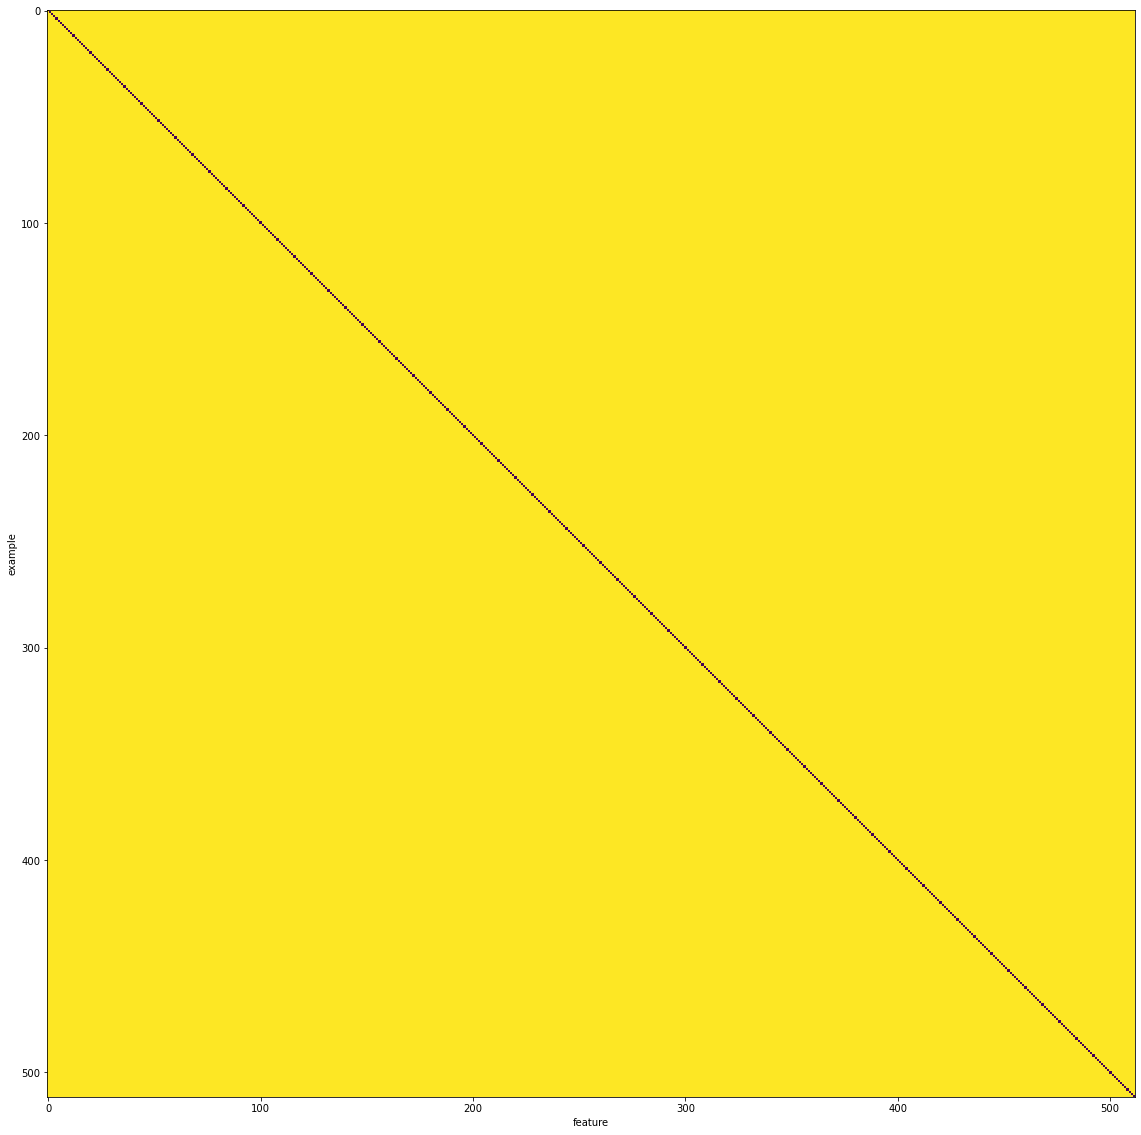

In [29]:
plt.figure(figsize=(20,20))
plt.imshow(all_but_one_vs, interpolation='nearest')
plt.xlabel('feature')
plt.ylabel('example')
plt.show()

## generate input features with varying sparsity

In [30]:
v = torch.rand((int(N), int(N)))

compare = torch.linspace(0,1,N) * torch.ones((int(N), int(N)))
sparsity = torch.bernoulli(compare).T
        
v *= sparsity
random_sparse_vs = torch.Tensor(v > 0).type(torch.float32) # convert to unit input amplitude

In [31]:
torch.sum(random_sparse_vs, axis=1)[0], torch.sum(random_sparse_vs, axis=1)[255], torch.sum(random_sparse_vs, axis=1)[-1]

(tensor(0.), tensor(255.), tensor(512.))

In [32]:
random_sparse_vs = random_sparse_vs.detach().numpy()

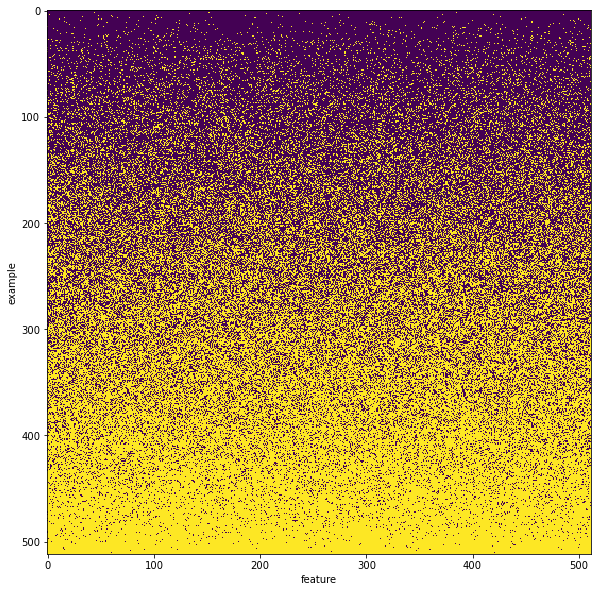

In [33]:
plt.figure(figsize=(10,10))
# plt.imshow(v)
plt.imshow(random_sparse_vs, interpolation='nearest')
plt.xlabel('feature')
plt.ylabel('example')
plt.show()

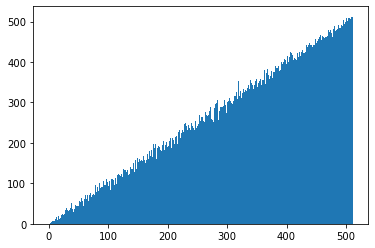

In [34]:
plt.bar(range(512), np.sum(random_sparse_vs, axis=1), width=1)
plt.show()

# Putting it together

## reload the penalised model

In [35]:
model = 'soft_dot_penalised_model' # this is the "penalised" model
lr = 0.001

fname = f"../my_models/{model}_{task}_{nonlinearity}_k_{k}_batch_{log2_batch_size}_steps_{log2_training_steps}_learning_rate_{lr}_sample_{sample_kind}_init_bias_{init_bias}_decay_{decay}_eps_{eps}_m_{m}_N_{N}_reg_{reg}.pt"

batch = torch.load(fname, map_location=torch.device('cpu'))
d = batch['log2_spaced_models'][0]

model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], nonlinearity)
model.load_state_dict(batch['log2_spaced_models'][-1])
model.to('cpu')

fixed_embedder = batch['setup']['fixed_embedder']

In [36]:
# calculate the single feature activations
sf_vs = torch.eye(N) # a matrix with only one feature active with unit amplitude. The number of examples matches the number of features.
ins = torch.matmul(sf_vs, fixed_embedder.T) # embed the above matrix with the fixed random embedder
sfa = model[:2].forward(ins).T.detach().numpy() # get the single feature activations of the hidden layer

In [37]:
# Sort the neurons to put the most-monosemantic first
inds1 = np.argsort(-np.amax(sfa,axis=1) / (1e-10 + np.mean(sfa,axis=1)))
sfa = sfa[inds1]

# Sort the features to put the most-monosemantic neurons first
neuron_inds = []
for i in range(sfa.shape[1]): # Loop over features
    neuron_ind = np.argmax(sfa[:,i]) # Find the neuron this feature activates most-strongly.
    neuron_inds.append(neuron_ind)
inds2 = np.argsort(neuron_inds) # Sort the neuron indices
sfa = sfa[:,inds2]

In [38]:
# calculate the all but one feature activations
all_but_one_vs = torch.ones(N, N) - torch.eye(N)
ins = torch.matmul(all_but_one_vs, fixed_embedder.T)
abofa = model[:2].forward(ins).T.detach().numpy()

In [39]:
# Sort the neurons to put the most-monosemantic first
inds_ = np.argsort(-np.amax(abofa,axis=1) / (1e-10 + np.mean(abofa,axis=1)))
abofa_ = abofa[inds_]

# Sort the features to put the most-monosemantic neurons first
neuron_inds_ = []
for i in range(abofa_.shape[1]): # Loop over features
    neuron_ind = np.argmax(abofa_[:,i]) # Find the neuron this feature activates most-strongly.
    neuron_inds_.append(neuron_ind)
inds_ = np.argsort(neuron_inds_) # Sort the neuron indices
abofa_ = abofa_[:,inds_]

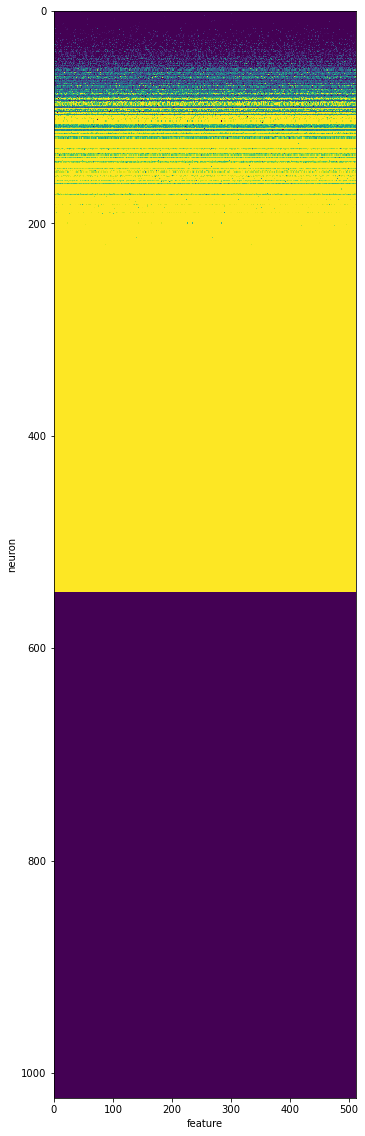

In [40]:
plt.figure(figsize=(20,20))
plt.imshow(abofa_, interpolation='nearest', aspect=1.8, vmin=0, vmax=1.02)
plt.xlabel('feature')
plt.ylabel('neuron')
plt.show()

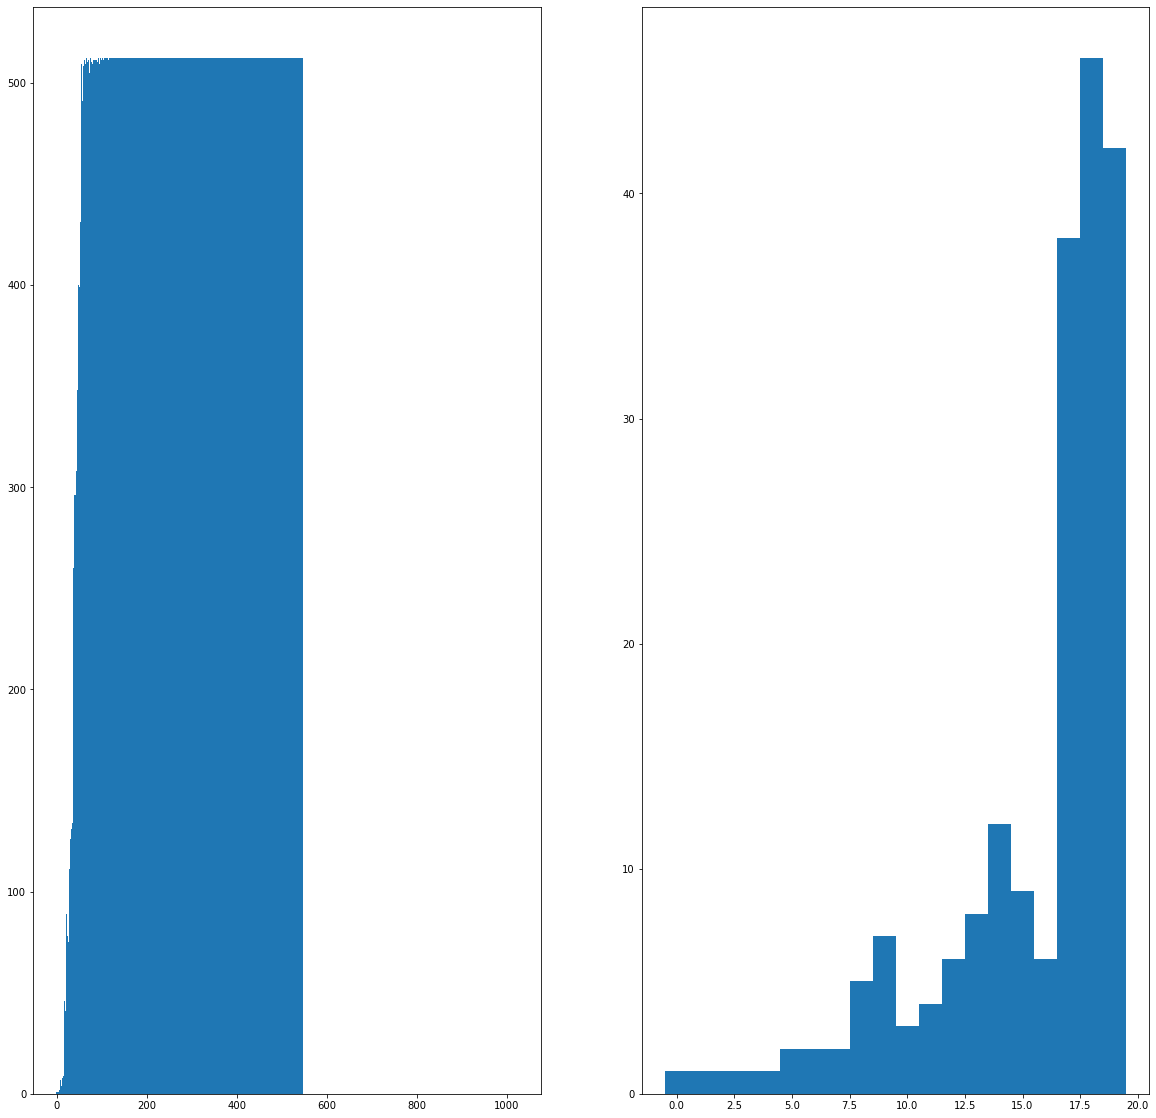

In [41]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax1.bar(range(1024), np.sum(abofa_>0, axis=1), width=1)
ax2 = fig.add_subplot(122)
ax2.bar(range(20), np.sum(abofa_>0, axis=1)[:20], width=1)
plt.show()

In [42]:
# calculate the sparse random feature activations
v = torch.rand((int(N), int(N)))

compare = torch.linspace(0,1,N) * torch.ones((int(N), int(N)))
sparsity = torch.bernoulli(compare).T
        
v *= sparsity

sparse_random_vs = torch.Tensor(v > 0).type(torch.float32)
ins = torch.matmul(sparse_random_vs, fixed_embedder.T)
srfa = model[:2].forward(ins).T.detach().numpy()

In [43]:
 # Sort the neurons to put the most-monosemantic first
inds_ = np.argsort(-np.amax(srfa,axis=1) / (1e-10 + np.mean(srfa,axis=1)))
srfa_ = srfa[inds_]

# Sort the features to put the most-monosemantic neurons first
neuron_inds_ = []
for i in range(srfa_.shape[1]): # Loop over features
    neuron_ind = np.argmax(srfa_[:,i]) # Find the neuron this feature activates most-strongly.
    neuron_inds_.append(neuron_ind)
inds_ = np.argsort(neuron_inds_) # Sort the neuron indices
srfa_ = srfa_[:,inds_]

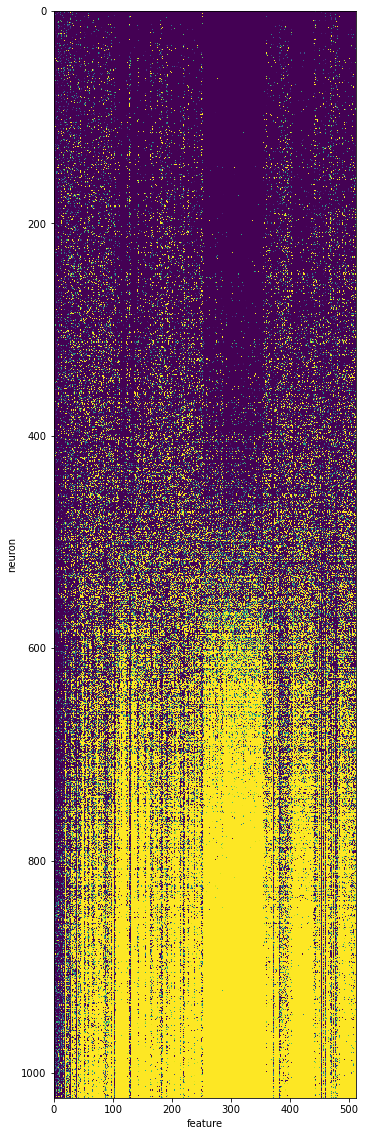

In [44]:
plt.figure(figsize=(20,20))
plt.imshow(srfa_, interpolation='nearest', aspect=1.8, vmin=0, vmax=1.02)
plt.xlabel('feature')
plt.ylabel('neuron')
plt.show()

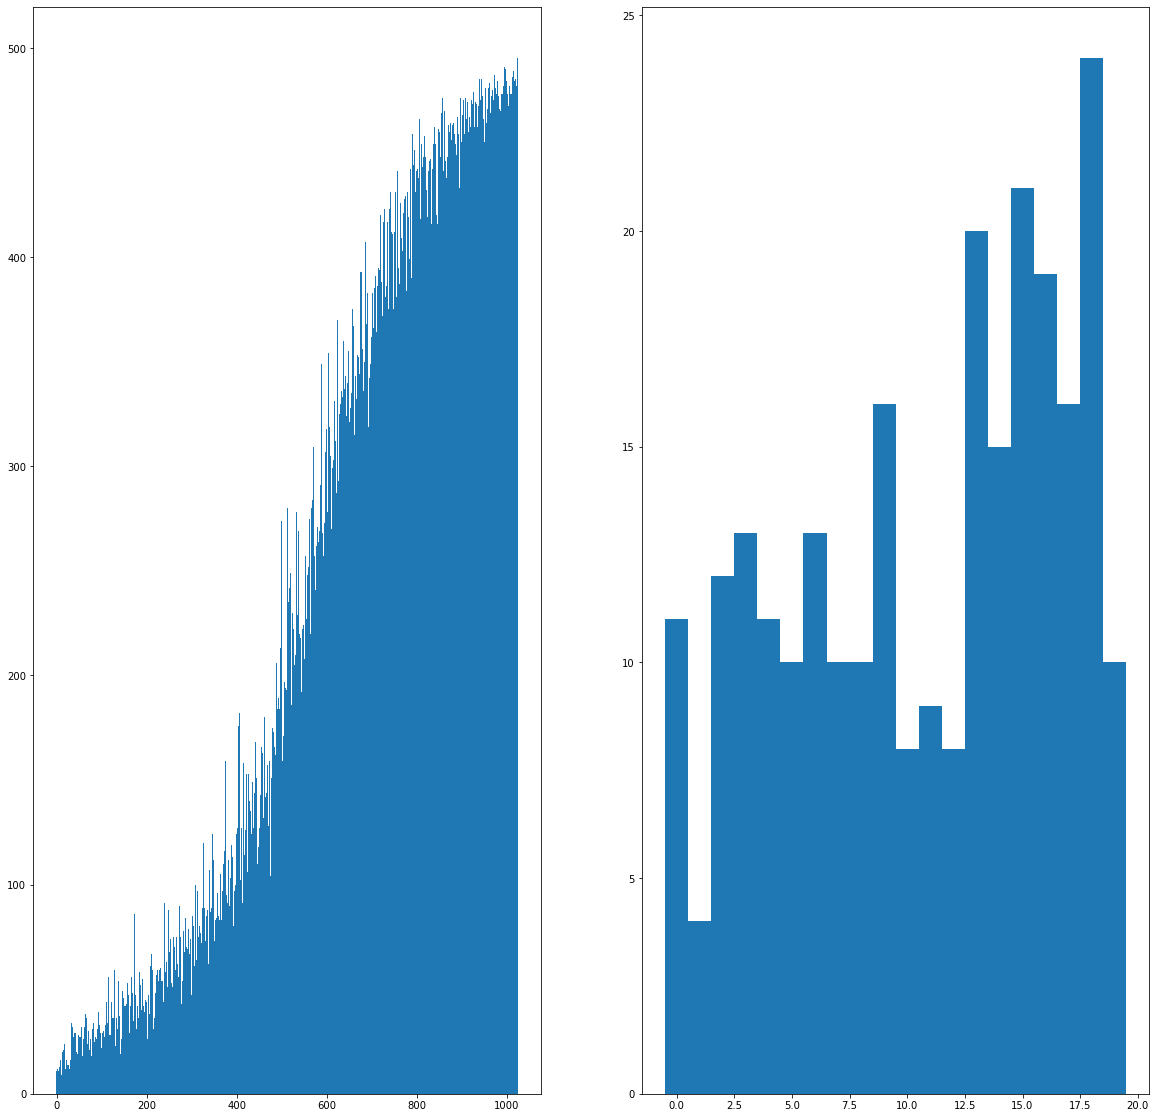

In [45]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax1.bar(range(1024), np.sum(srfa_>0, axis=1), width=1)
ax2 = fig.add_subplot(122)
ax2.bar(range(20), np.sum(srfa_>0, axis=1)[:20], width=1)
plt.show()

In [46]:
unit_sfa = torch.Tensor(sfa>0).type(torch.float32)
unit_abofa = torch.Tensor(abofa>0).type(torch.float32)

In [47]:
torch.Tensor(torch.sum(unit_sfa, axis=1) == 1).type(torch.float32)

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [48]:
torch.Tensor(torch.sum(unit_sfa, axis=1) == 1).type(torch.float32).shape

torch.Size([1024])

In [49]:
unit_sfa_mono_mask = torch.Tensor(torch.sum(unit_sfa, axis=1) == 1).type(torch.float32).repeat(N,1).T

In [50]:
unit_sfa_mono_mask.shape

torch.Size([1024, 512])

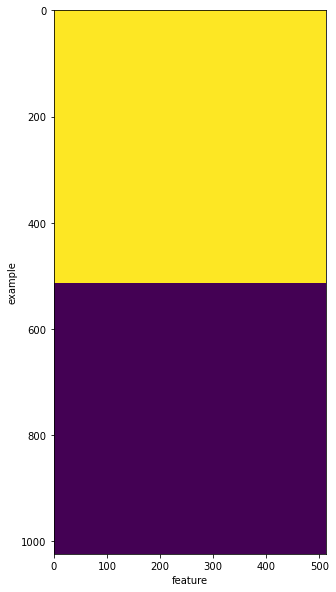

In [51]:
plt.figure(figsize=(10,10))
# plt.imshow(v)
plt.imshow(unit_sfa_mono_mask, interpolation='nearest')
plt.xlabel('feature')
plt.ylabel('example')
plt.show()

In [52]:
unit_abofa = unit_abofa[inds1][:,inds2]

In [53]:
torch.Tensor(torch.sum(unit_abofa, axis=1) == 1).type(torch.float32).shape

torch.Size([1024])

In [54]:
unit_abofa_mono_mask = torch.Tensor(torch.sum(unit_abofa, axis=1) == 1).type(torch.float32).repeat(N,1).T

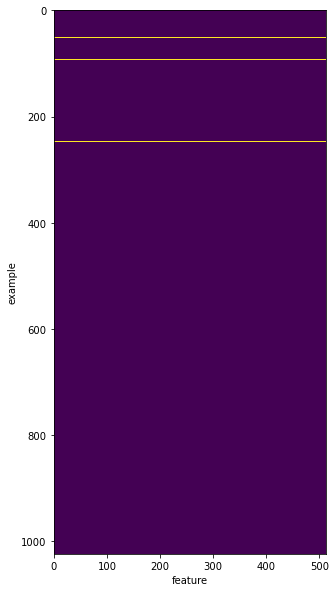

In [55]:
plt.figure(figsize=(10,10))
# plt.imshow(v)
plt.imshow(unit_abofa_mono_mask, interpolation='nearest')
plt.xlabel('feature')
plt.ylabel('example')
plt.show()

In [56]:
torch.sum(unit_abofa_mono_mask[:,0])

tensor(5.)

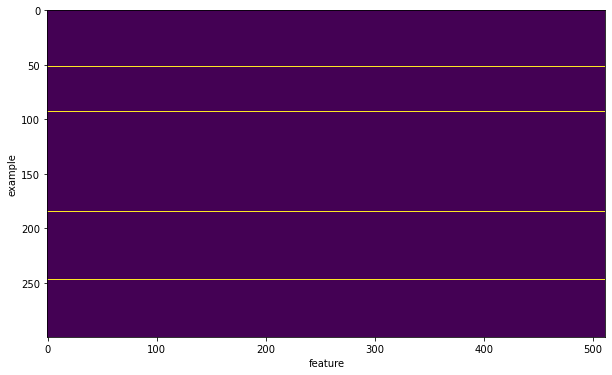

In [57]:
plt.figure(figsize=(10,10))
# plt.imshow(v)
plt.imshow(unit_abofa_mono_mask[:300], interpolation='nearest')
plt.xlabel('feature')
plt.ylabel('example')
plt.show()

In [58]:
(unit_sfa * unit_sfa_mono_mask) * (unit_abofa[inds1][:,inds2] * unit_abofa_mono_mask)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

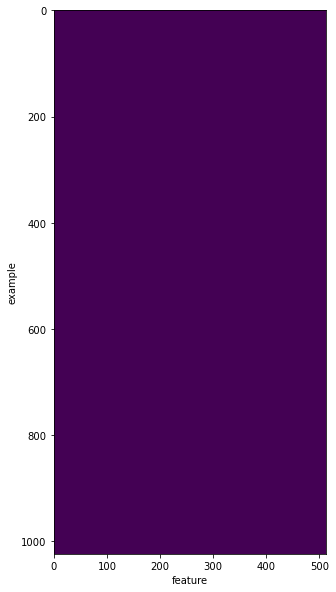

In [59]:
plt.figure(figsize=(10,10))
# plt.imshow(v)
plt.imshow((unit_sfa * unit_sfa_mono_mask) * (unit_abofa * unit_abofa_mono_mask), interpolation='nearest')
plt.xlabel('feature')
plt.ylabel('example')
plt.show()

In [60]:
x = (unit_sfa * unit_sfa_mono_mask) * (unit_abofa * unit_abofa_mono_mask)
print(x.shape)
print(np.where(x==1))

torch.Size([1024, 512])
(array([], dtype=int64), array([], dtype=int64))


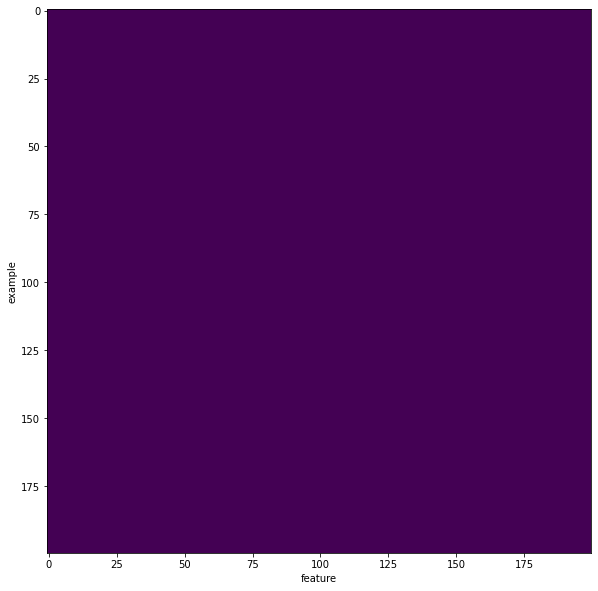

In [61]:
plt.figure(figsize=(10,10))
# plt.imshow(v)
plt.imshow(x[:200,:200], interpolation='nearest')
plt.xlabel('feature')
plt.ylabel('example')
plt.show()

In [62]:
loss = 1 - (torch.sum((unit_sfa * unit_sfa_mono_mask) * (unit_abofa * unit_abofa_mono_mask))) / k

In [63]:
loss

tensor(1.)

# reimplementation without reordering

In [64]:
model = 'soft_dot_penalised_model' # this is the "penalised" model
lr = 0.005

fname = f"../my_models/{model}_{task}_{nonlinearity}_k_{k}_batch_{log2_batch_size}_steps_{log2_training_steps}_learning_rate_{lr}_sample_{sample_kind}_init_bias_{init_bias}_decay_{decay}_eps_{eps}_m_{m}_N_{N}_reg_{reg}.pt"

batch = torch.load(fname, map_location=torch.device('cpu'))
d = batch['log2_spaced_models'][0]

model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], nonlinearity)
model.load_state_dict(batch['log2_spaced_models'][-1])
model.to('cpu')

fixed_embedder = batch['setup']['fixed_embedder']

In [65]:
# calculate the single feature activations
sf_vs = torch.eye(N) # a matrix with only one feature active with unit amplitude. The number of examples matches the number of features.
ins = torch.matmul(sf_vs, fixed_embedder.T) # embed the above matrix with the fixed random embedder
sfa = model[:2].forward(ins).T.detach().numpy() # get the single feature activations of the hidden layer

In [66]:
# calculate the all but one feature activations
all_but_one_vs = torch.ones(N, N) - torch.eye(N)
ins = torch.matmul(all_but_one_vs, fixed_embedder.T)
abofa = model[:2].forward(ins).T.detach().numpy()

In [67]:
unit_sfa = torch.Tensor(sfa>0).type(torch.float32)
unit_abofa = torch.Tensor(abofa>0).type(torch.float32)

In [68]:
unit_sfa_mono_mask = torch.Tensor(torch.sum(unit_sfa, axis=1) == 1).type(torch.float32).repeat(N,1).T
unit_abofa_mono_mask = torch.Tensor(torch.sum(unit_abofa, axis=1) == 1).type(torch.float32).repeat(N,1).T

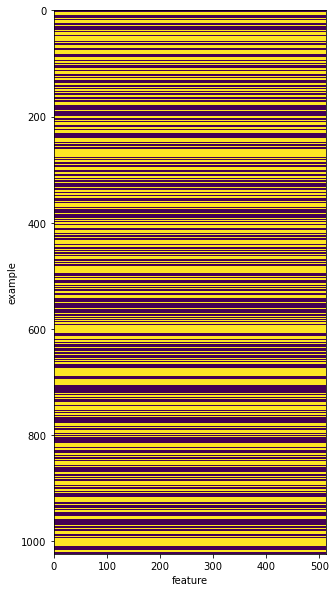

In [69]:
plt.figure(figsize=(10,10))
# plt.imshow(v)
plt.imshow(unit_sfa_mono_mask, interpolation='nearest')
plt.xlabel('feature')
plt.ylabel('example')
plt.show()

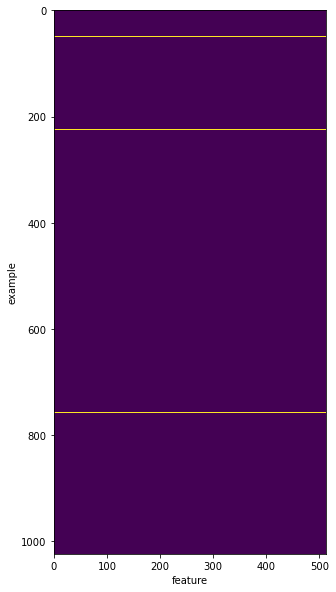

In [70]:
plt.figure(figsize=(10,10))
# plt.imshow(v)
plt.imshow(unit_abofa_mono_mask, interpolation='nearest')
plt.xlabel('feature')
plt.ylabel('example')
plt.show()

In [71]:
torch.sum(unit_abofa_mono_mask[:,0])

tensor(7.)

In [72]:
x = (unit_sfa * unit_sfa_mono_mask) * (unit_abofa * unit_abofa_mono_mask)

In [73]:
torch.sum(x)

tensor(0.)

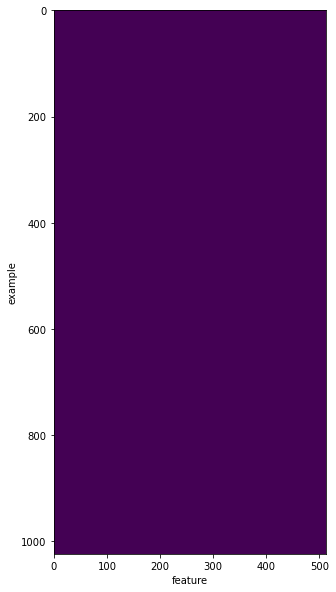

In [74]:
plt.figure(figsize=(10,10))
# plt.imshow(v)
plt.imshow(x, interpolation='nearest')
plt.xlabel('feature')
plt.ylabel('example')
plt.show()

In [75]:
loss = 1 - (torch.sum(x)) / k

In [76]:
loss

tensor(1.)

# modification to make the penalisation softer by counting the total number of neurons activating

In [77]:
k, N

(1024, 512)

In [78]:
k*N

524288

In [79]:
torch.sum(unit_sfa)

tensor(512.)

In [80]:
(torch.sum(unit_sfa) - 1024) / (k*N)

tensor(-0.0010)

In [81]:
torch.sum(unit_abofa)

tensor(190590.)

In [82]:
(torch.sum(unit_abofa) - 1024) / (k*N)

tensor(0.3616)

In [83]:
unit_srfa = torch.Tensor(srfa>0).type(torch.float32)

In [84]:
torch.sum(unit_srfa)

tensor(239729.)

In [85]:
(torch.sum(unit_srfa) - 1024) / (k*N)

tensor(0.4553)

In [86]:
((torch.sum(unit_sfa) + torch.sum(unit_abofa) + torch.sum(unit_srfa)) - 3*k) / (k*N)

tensor(0.8159)

All of the above rely on taking the L0-norm of the activations which is not differentiable.

# Differentiable

In [87]:
model = 'soft_dot_penalised_model' # this is the "penalised" model
lr = 0.005

fname = f"../my_models/{model}_{task}_{nonlinearity}_k_{k}_batch_{log2_batch_size}_steps_{log2_training_steps}_learning_rate_{lr}_sample_{sample_kind}_init_bias_{init_bias}_decay_{decay}_eps_{eps}_m_{m}_N_{N}_reg_{reg}.pt"

batch = torch.load(fname, map_location=torch.device('cpu'))
d = batch['log2_spaced_models'][0]

model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], nonlinearity)
model.load_state_dict(batch['log2_spaced_models'][-1])
model.to('cpu')

fixed_embedder = batch['setup']['fixed_embedder']

In [88]:
# calculate the single feature activations
sf_vs = torch.eye(N) # a matrix with only one feature active with unit amplitude. The number of examples matches the number of features.
ins = torch.matmul(sf_vs, fixed_embedder.T) # embed the above matrix with the fixed random embedder
sfa = model[:2].forward(ins).T.detach().numpy() # get the single feature activations of the hidden layer

In [89]:
# Sort the neurons to put the most-monosemantic first
inds1 = np.argsort(-np.amax(sfa,axis=1) / (1e-10 + np.mean(sfa,axis=1)))
sfa = sfa[inds1]

# Sort the features to put the most-monosemantic neurons first
neuron_inds = []
for i in range(sfa.shape[1]): # Loop over features
    neuron_ind = np.argmax(sfa[:,i]) # Find the neuron this feature activates most-strongly.
    neuron_inds.append(neuron_ind)
inds2 = np.argsort(neuron_inds) # Sort the neuron indices
sfa = sfa[:,inds2]

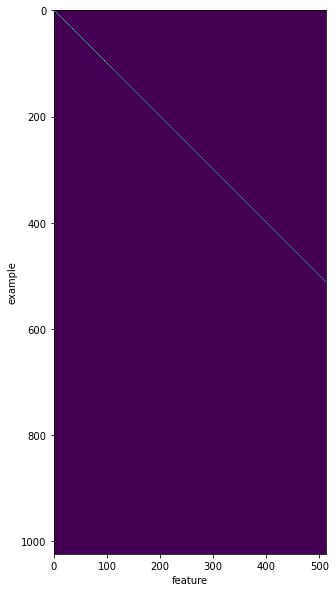

In [90]:
plt.figure(figsize=(10,10))
# plt.imshow(v)
plt.imshow(sfa, interpolation='nearest')
plt.xlabel('feature')
plt.ylabel('example')
plt.show()

In [91]:
# calculate the all but one feature activations
all_but_one_vs = torch.ones(N, N) - torch.eye(N)
ins = torch.matmul(all_but_one_vs, fixed_embedder.T)
abofa = model[:2].forward(ins).T.detach().numpy()

In [92]:
abofa = abofa[inds1][:,inds2]

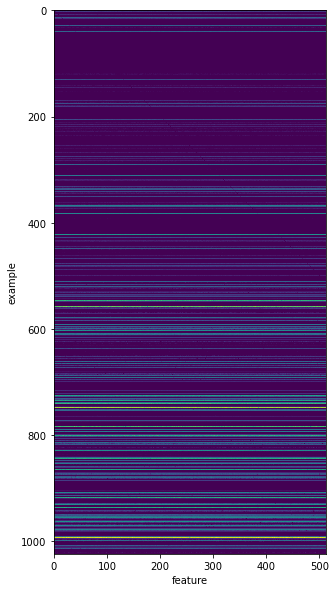

In [93]:
plt.figure(figsize=(10,10))
# plt.imshow(v)
plt.imshow(abofa, interpolation='nearest')
plt.xlabel('feature')
plt.ylabel('example')
plt.show()

In [94]:
dot = np.dot(sfa, abofa.T)

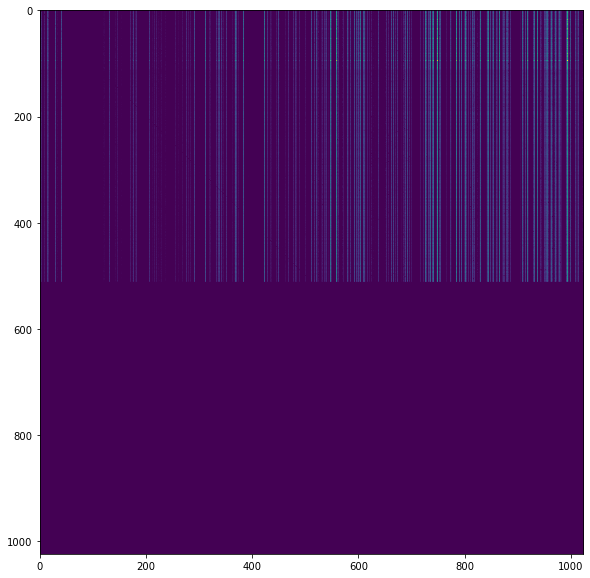

In [95]:
plt.figure(figsize=(10,10))
# plt.imshow(v)
plt.imshow(dot, interpolation='nearest')
plt.show()

In [96]:
np.sum(np.tril(dot, -1)) / (N * (N - 1)) # calculate the loss

0.1962383889872034

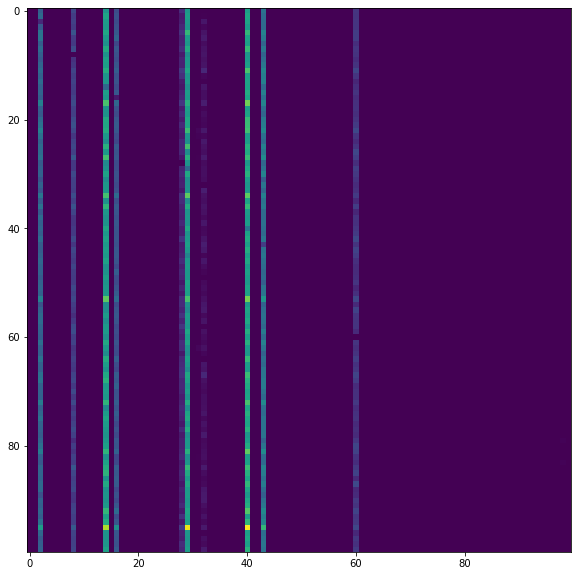

In [97]:
plt.figure(figsize=(10,10))
# plt.imshow(v)
plt.imshow(dot[:100,:100], interpolation='nearest')
plt.show()

# Jacob's Implementation

In [153]:
def gen_inputs_no_feat(N,feat):
    
    # create random N by N matrix
    # -- each row represents a single random input to the NN
    # -- columns represent unique features
    v = torch.rand((int(N), int(N)))
    
    # create column vector with N elements equally spaced from 0 to 1
    # rep horizontally to be the same size as 'v
    # -- each element in a row has the same value
    # -- this value increases at a constant rate from 0 in the first row to 1 in the final row
    compare = torch.linspace(0,1,N) * torch.ones((int(N), int(N)))
    
    # create a sparsity matrix using 'compare'
    # -- each element in 'sparsity' will be randomly assigned 0 or 1
    # -- probability is dependent on value of corresponding element in 'compare'
    sparsity = torch.bernoulli(compare).T
    
    # multiply with 'v' to create random entries with prescribed sparsity
    # -- each row is now a single input with prescribed sparsity
    # -- which begins at 0 and increases steadily to 1 at row N
    # -- but the value of each entry that is not 0 is determined randomly
    v *= sparsity
        
    # convert to unit input amplitude
    # -- switch the values back to being either 0 or 1
    # -- why did we generate the original random 'v' then, and why didn't we just use 'sparsity'
    v = torch.Tensor(v > 0).type(torch.float32)
    
    # note that this produces an N by N matrix of TRUE
#     print( v == sparsity )
    
    # set input of the feature 'feat' to always be zero
    # -- this step makes sure that a specific random feature ('feat') 
    # -- won't ever be used in any of these random inputs
#     v[:,feat] = torch.zeros(1, int(N))
    
    # generate plot for verification
    # -- should appear as a smooth gradient between only 0s appearing to only 1s appearing
    # -- except for a single column, which should always be 0
#     plt.figure(figsize=(10,10))
#     plt.imshow(v.detach().numpy(), interpolation='nearest')
#     plt.xlabel('feature')
#     plt.ylabel('input')
#     plt.show()
    
    return v

Feature Index: 301
SFI Hidden Layer
  Index of Neuron with Max Activation: 89
  Value of Max Activation: 0.8455336
  Sum of Hidden Layer Activations: 0.8455336
  Sum of Activations - Max Activation: 0.0
(1024, 512)
(512,)
Proposed Loss Value: 0.11183117236942053


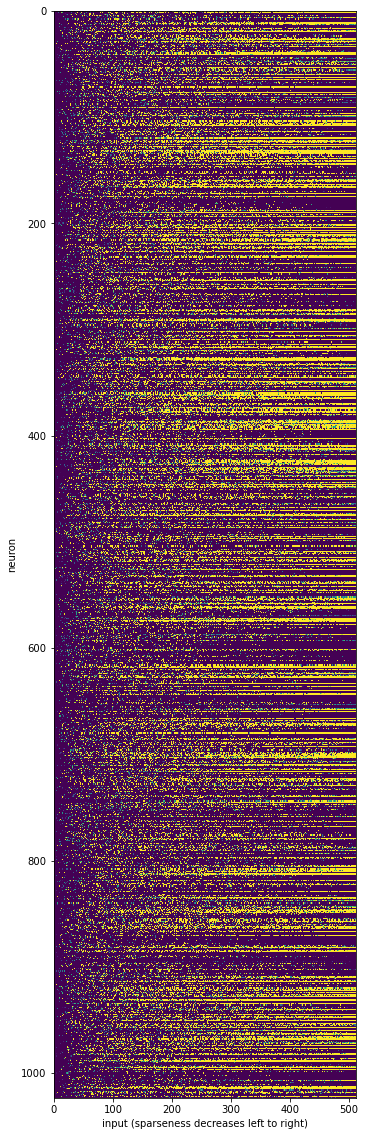

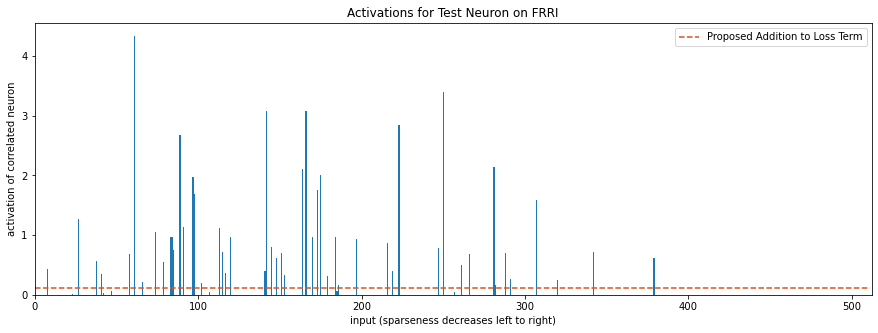

Feature Index: 314
SFI Hidden Layer
  Index of Neuron with Max Activation: 387
  Value of Max Activation: 0.7504584
  Sum of Hidden Layer Activations: 0.7504584
  Sum of Activations - Max Activation: 0.0
(1024, 512)
(512,)
Proposed Loss Value: 1.6681787630077451


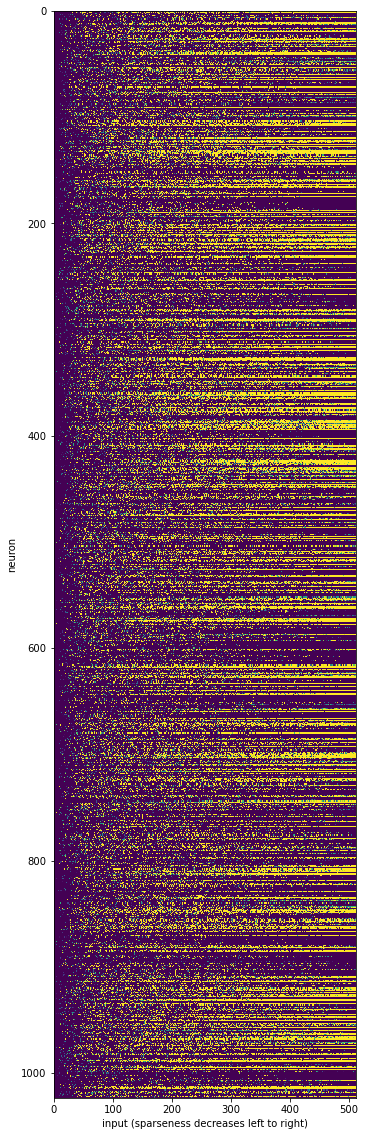

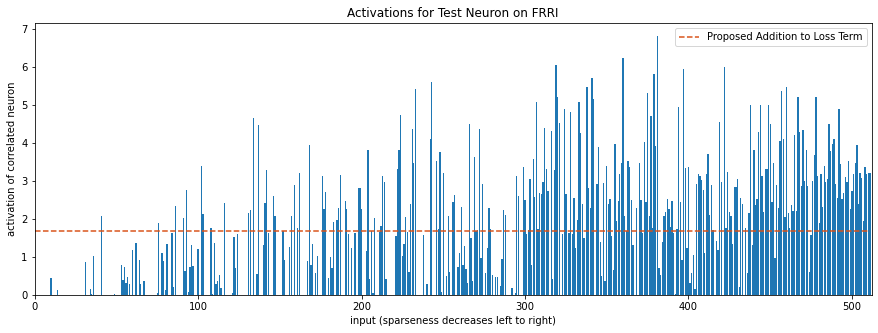

Feature Index: 359
SFI Hidden Layer
  Index of Neuron with Max Activation: 609
  Value of Max Activation: 0.7944552
  Sum of Hidden Layer Activations: 0.7944552
  Sum of Activations - Max Activation: 0.0
(1024, 512)
(512,)
Proposed Loss Value: 0.05031257850350812


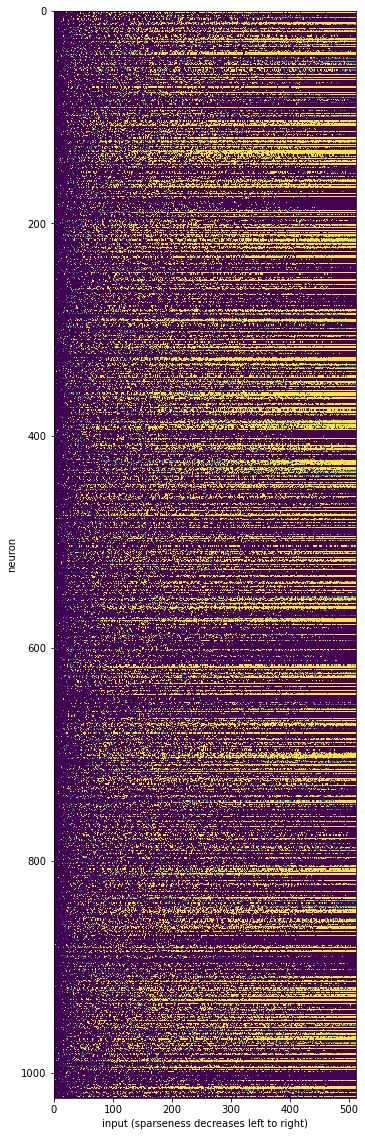

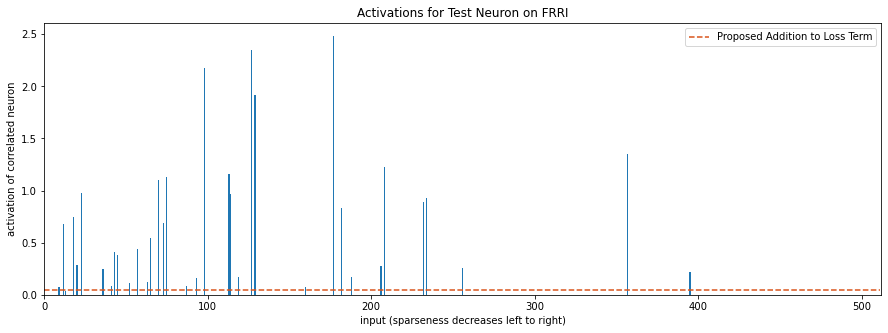

In [155]:
for in_feat in np.random.randint(N, size=3): #int(.15*N)
    # 'in_feat' = the feature designated to be tested
    print("Feature Index: " + str(in_feat))
    
    ##### DETERMINE CORRELATED NEURON USING SFI #####
    # create an input where all elements are 0 except fot the feature to be tested 'in_feat'
    # -- make a vector of 0s, then set the element at index 'in_feat' to be 1
    # -- this is called the single feature input ('single_feat_input' or SFI)
    single_feat_input = torch.zeros(N)
    single_feat_input[in_feat] += 1
    
    # use the embedder to find the output of our neural network
    # -- when only one feature ('in_feat') is activated
    single_feat_embed = torch.matmul(single_feat_input, fixed_embedder.T)
    
    # extract the activations of the hidden layer for this single feature input
    single_feat_hidden = model[:2].forward(single_feat_embed).T.detach().numpy()
    
    # determine if this single input excites only one neuron in the hidden layer
    # -- if the element with the largest value in the hidden layer is equivalent 
    # -- to the sum of the hidden layer, then only one neuron fired for this SFI
    single_max_ind = np.argmax(single_feat_hidden)
    single_max_val = np.max(single_feat_hidden)
    single_sum = np.sum(single_feat_hidden)
#     single_dot = np.dot(single_feat_hidden, single_feat_hidden.T) # this just squares our max val
    
    # some print statements for verification
    print("SFI Hidden Layer")
    print("  Index of Neuron with Max Activation: " + str(single_max_ind))
    print("  Value of Max Activation: " + str(single_max_val))
    print("  Sum of Hidden Layer Activations: " + str(single_sum))
    print("  Sum of Activations - Max Activation: " + str(single_sum - single_max_val))
#     print("  Dot Product of Activations with Themselves: " + str(single_dot))
    
    ##### CALCULATE LOSS FROM FRRI #####
    # create an N by N matrix, where each row represents an input
    # -- this is called the feature removed random inputs ('feat_rmvd_rand_inps' or FRRI)
    # -- see 'gen_inputs_no_feat' definition for further details
    feat_rmvd_rand_inps = gen_inputs_no_feat(N,in_feat)
    
    # use the embedder to find the output of our neural network
    # -- this means we will have N inputs (rows) with varying sparsity
    # -- each entry excludes the feature we are testing ('in_feat')
    feat_rmvd_embed = torch.matmul(feat_rmvd_rand_inps, fixed_embedder.T)
    
    # extract the activations of the hidden layer for this set of FRRI
    # -- in output matrix, each row represents a single neuron's activations
    # -- and each column is a different 
    
    feat_rmvd_hidden = model[:2].forward(feat_rmvd_embed).T.detach().numpy()
    print(feat_rmvd_hidden.shape)
    
    # penalize network when neuron most correlated with our test feature activates
    # -- from our SFI, we have the neuron that is the most active for our test feature
    # -- isolate the column corresponding to the correlated neuron
    corr_neuron_acts = feat_rmvd_hidden[single_max_ind,:]
    print(corr_neuron_acts.shape)
    
    # take the average activation that this feature has across the FRRI
    more_loss = sum(corr_neuron_acts)/N
    print("Proposed Loss Value: " + str(more_loss))
    
    # this plot shows 
    # -- the activations (color) 
    # -- of each neuron (y axis) 
    # -- for various inputs (x axis)
    plt.figure(figsize=(20,20))
    plt.imshow(feat_rmvd_hidden, interpolation='nearest', aspect=1.8, vmin=0, vmax=1.02)
    plt.xlabel('input (sparseness decreases left to right)')
    plt.ylabel('neuron')
    plt.show()
    
    # this plot is a different representation of a single row in the previous plot
    # -- specifically, the row corresponding to the test feature 'in_feat'
    plt.figure(figsize=(15,5))
    plt.bar(list(range(N)),corr_neuron_acts,label='_activations')
    plt.plot(list(range(N)),np.repeat(more_loss,N),color="#D95319",ls='--',label='Proposed Addition to Loss Term')
    plt.title('Activations for Test Neuron on FRRI')
    plt.xlabel('input (sparseness decreases left to right)')
    plt.xlim([0,512])
    plt.ylabel('activation of correlated neuron')
    plt.legend()
    plt.show()

This approach works by randomly choosing a subset of input features during each batch update. It identifies the neuron that activates most strongly for each of the test features given single feature inputs of unit amplitude.  For each test feature additional inputs of unit amplitude with features active with different sparsities are generated, while ensuring the test feature is always inactive. In the hidden activations for these inputs, the activations corresponding to the most active neuron for each test feature is isolated. The model is penalised for the mean activation of this neuron across the inputs of differing sparsity.

## vectorising

In [133]:
def gen_inputs_no_feat_vec(N, feats, n_feats):
    
    v = torch.rand((n_feats, N, N))
    print(v.shape)

    compare = torch.linspace(0,1,N) * torch.ones((N, N))
    compare = compare.T.unsqueeze(0).repeat(n_feats, 1, 1)
    sparsity = torch.bernoulli(compare)
    print(sparsity.shape)

    v *= sparsity

    v[range(n_feats),:,feats] = 0

    return torch.Tensor(v > 0).type(torch.float32)
#     return v

In [134]:
N = 512
test_feats = [100, 256, 300]
n_test_feats = len(test_feats)
x = gen_inputs_no_feat_vec(N, test_feats, n_test_feats)
print(x[0,-1,-10:])

torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


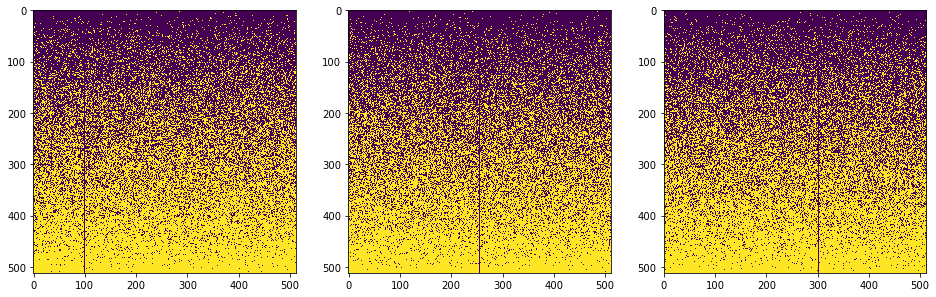

In [135]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
ax1.imshow(x[0], interpolation='nearest')
ax2.imshow(x[1], interpolation='nearest')
ax3.imshow(x[2], interpolation='nearest')
plt.show()

In [187]:
test_feats = torch.randint(0, N, size=(N//2,))
print(test_feats)
n_test_feats = len(test_feats)

tensor([377, 291, 505, 236, 293, 293, 367, 198, 305,  77, 355, 348, 227, 194,
        218, 372, 228, 442, 317, 207, 183, 138,  19, 366, 485, 410, 235, 378,
         89, 441, 387,  54, 243,  11, 472, 125, 271,  19, 147, 181, 149, 141,
         60, 455, 337,  69,  27, 405, 419, 313, 229, 410,  10, 145, 322, 304,
         41, 320, 363, 193, 386, 283, 235,   0,  52,  80,  63, 435, 291, 425,
        398, 106, 365, 451, 148, 212,  56, 113,  79,  25,  31, 380, 475, 116,
         40, 321, 402, 366,  33,  76, 471, 296, 427, 347, 309, 317,  87, 508,
        176, 415, 350, 390, 258, 418, 465, 470, 379, 404, 210, 432, 127, 253,
          6,  33, 473, 273, 332, 382, 386, 352, 249, 164,  32, 142, 198, 290,
        415, 371,  24, 471, 215, 211, 234, 309, 402, 168, 244, 271, 475,  89,
        216, 446,  61, 510, 395, 268, 104, 417, 415, 406, 180,  73, 249, 288,
        310, 399,  96,   1, 448, 435,  50, 156, 373, 381, 308, 298, 266,  35,
        398, 113, 354,  21, 210, 365, 136, 115, 484,  97, 201, 4

In [188]:
single_feat_input = torch.eye(N, N)
print(single_feat_input.shape)
print(single_feat_input[:,:10])

torch.Size([512, 512])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [189]:
single_feat_embed = torch.matmul(single_feat_input, fixed_embedder.T)
single_feat_hidden = model[:2].forward(single_feat_embed)
print(single_feat_hidden.shape)

torch.Size([512, 1024])


In [190]:
single_max_val, single_max_ind = torch.max(single_feat_hidden[test_feats], axis=1)
print(single_max_val)
print(single_max_ind)
single_sum = torch.sum(single_feat_hidden[test_feats], axis=1)
print(single_sum)

tensor([0.7815, 0.8077, 0.9322, 0.9100, 0.7674, 0.7674, 0.8391, 0.7839, 0.8597,
        1.1206, 0.9448, 0.9167, 0.9985, 0.8239, 1.3573, 1.0437, 1.0689, 0.9613,
        1.1068, 0.8729, 0.8321, 0.9878, 0.8455, 1.0715, 0.9170, 0.9170, 0.8882,
        0.8677, 0.8672, 0.8648, 0.8414, 0.8338, 1.0223, 0.8457, 0.7648, 0.8357,
        0.8736, 0.8455, 0.9597, 0.7665, 0.9591, 1.0293, 0.7451, 1.0116, 1.8187,
        0.8199, 1.0210, 0.8158, 1.0025, 0.9167, 0.8594, 0.9170, 0.8579, 0.7973,
        1.0896, 0.8735, 0.9059, 1.0440, 0.9379, 0.9575, 0.7777, 0.8949, 0.8882,
        0.7868, 0.7980, 1.0332, 0.8772, 0.8361, 0.8077, 0.8906, 0.8427, 0.7984,
        0.8160, 0.9687, 0.9841, 0.8477, 1.0530, 1.4712, 0.9062, 0.8195, 0.8012,
        0.8592, 0.8035, 1.1913, 1.2348, 0.9164, 0.8573, 1.0715, 0.9810, 1.0037,
        0.7947, 0.8156, 0.8484, 0.8636, 1.0810, 1.1068, 1.0767, 1.0338, 1.0009,
        0.8058, 0.8316, 1.0671, 0.8620, 0.9584, 0.7594, 1.0043, 0.7670, 0.9338,
        0.7876, 0.9047, 0.9453, 1.0059, 

In [191]:
feat_rmvd_rand_inps = gen_inputs_no_feat_vec(N, test_feats, n_test_feats)
feat_rmvd_embed = torch.matmul(feat_rmvd_rand_inps, fixed_embedder.T)
print(feat_rmvd_embed.shape)

torch.Size([256, 512, 512])
torch.Size([256, 512, 512])
torch.Size([256, 512, 64])


In [192]:
feat_rmvd_hidden = model[:2].forward(feat_rmvd_embed)
print(feat_rmvd_hidden.shape)

torch.Size([256, 512, 1024])


In [193]:
corr_neuron_acts = feat_rmvd_hidden[range(n_test_feats),:,single_max_ind]
print(corr_neuron_acts.shape)

torch.Size([256, 512])


In [194]:
torch.all(corr_neuron_acts[2] == feat_rmvd_hidden[2,:,single_max_ind[2]])

tensor(True)

In [195]:
more_loss = torch.sum(corr_neuron_acts)/(n_test_feats*N)
print("Proposed Loss Value: " + str(more_loss))

Proposed Loss Value: tensor(0.2544, grad_fn=<DivBackward0>)


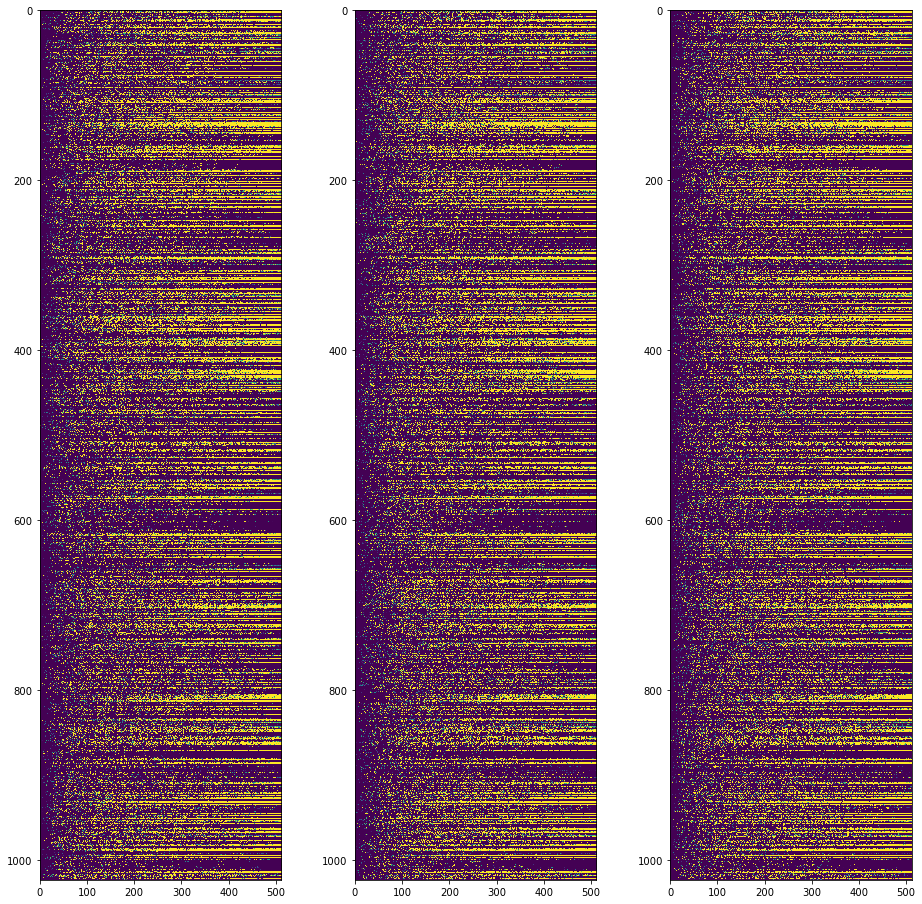

In [196]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,16))
ax1.imshow(feat_rmvd_hidden[0].T.detach().numpy(), interpolation='nearest', aspect=1.8, vmin=0, vmax=1.02)
ax2.imshow(feat_rmvd_hidden[1].T.detach().numpy(), interpolation='nearest', aspect=1.8, vmin=0, vmax=1.02)
ax3.imshow(feat_rmvd_hidden[2].T.detach().numpy(), interpolation='nearest', aspect=1.8, vmin=0, vmax=1.02)
# plt.xlabel('input (sparseness decreases left to right)')
# plt.ylabel('neuron')
plt.show()

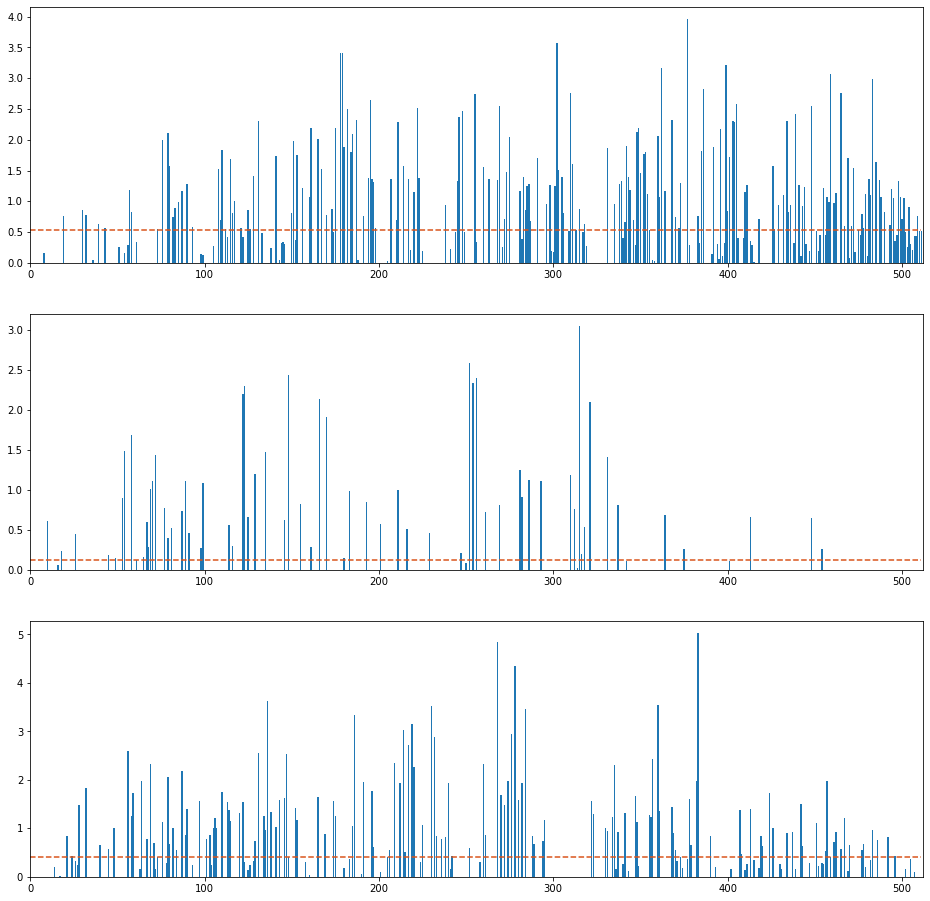

In [197]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16,16))
ax1.bar(list(range(N)), corr_neuron_acts[0].detach().numpy(), label='_activations')
ax1.plot(list(range(N)),np.repeat(torch.sum(corr_neuron_acts[0]).detach().numpy()/N, N),color="#D95319",ls='--',label='Proposed Addition to Loss Term')
ax1.set_xlim([0,512])
ax2.bar(list(range(N)), corr_neuron_acts[1].detach().numpy(), label='_activations')
ax2.plot(list(range(N)),np.repeat(torch.sum(corr_neuron_acts[1]).detach().numpy()/N, N),color="#D95319",ls='--',label='Proposed Addition to Loss Term')
ax2.set_xlim([0,512])
ax3.bar(list(range(N)), corr_neuron_acts[2].detach().numpy(), label='_activations')
ax3.plot(list(range(N)),np.repeat(torch.sum(corr_neuron_acts[2]).detach().numpy()/N, N),color="#D95319",ls='--',label='Proposed Addition to Loss Term')
ax3.set_xlim([0,512])
# plt.plot(list(range(N)),np.repeat(more_loss,N),color="#D95319",ls='--',label='Proposed Addition to Loss Term')
# plt.title('Activations for Test Neuron on FRRI')
# plt.xlabel('input (sparseness decreases left to right)')
# plt.ylabel('activation of correlated neuron')
# plt.legend()
plt.show()